# Geographical-based friendship network<!-- omit in toc-->

Luca Di Bello, University of Italian Switzerland (USI), 2023

## Table of contents<!-- omit in toc-->

- [Project description](#project-description)
- [Inhabitant maps](#inhabitant-maps)
  - [Purely random map](#purely-random-map)
  - [Geographical-based random map](#geographical-based-random-map)
  - [Friendship network](#friendship-network)

## Project description

Social networks are systems that map the relationships and interactions between individuals. Although social networks are typically dynamic, the focus of this project is put on a static example.

Geographical distance plays a crucial role in social network formation, with closer physical proximity typically leading to more frequent and stronger social ties.

Additionally, geographical features, such as the density of people in an area (more in cities and less in remote mountainous regions), profoundly influence the composition and scale of these networks, shaping the diversity and connectivity of communities within a given region.

## Inhabitant maps

The project features two kinds of inhabitant maps:

### Purely random map

1000 inhabitants are randomly distributed across a unit square map, $[0,1]^2$. Each individual is assigned a uniform random position $(x,y)$ in the map.

### Geographical-based random map

This map features several geographical areas $F$, such as cities, mountains, and lakes. The inhabitants are randomly distributed across the map, but the density of inhabitants is higher in cities and lower in mountains and lakes. The function $f$ maps the coordinates $(x, y)$ of an individual to the geographical area $f$ in which the individual is located.

$$
f(x,y) = \text{geographical area in which individual } (x,y) \text{ is located}
$$
  
In this map, individuals are no longer distributed uniformly at random across the map. Instead, the density of inhabitants depends on specific geographical features: each area has a positive factor that determines the ease of living there:

$$
s_f = \text{ease of living in area } f \ \forall f \in F
$$

The probability of a random individual being located in coordinates $(x,y)$ is the following:

$$
P(\text{random person settles in } (x,y)) = \frac{s_{f(x,y)}}{\sum_{(x',y') \in \text{Map}} s_{f(x',y')}}
$$

## Friendship network

$$
\textcolor{red}{\textbf{FINISH THIS WHEN I HAVE SOME TIME}}
$$

## Implementation

In [6]:
# Import required packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import igraph as ig
import seaborn as sns

> **Note:** The code documentation follows the [Google Python Style Guide](https://google.github.io/styleguide/pyguide.html).

### Scenario 1

#### A - Design for the random inhabitant map and friendship network

In this section will be defined useful functions, needed to accomplish next parts of the project

$\textcolor{red}{\textbf{FIX THIS DESCRIPTION WITH CHATGPT}}$

##### A.1 - Sampling individuals

The function `sample_uniform_random_individuals` samples $n$ individuals randomly from a unit square map $[0,1]^2$.

Pseudocode:

```
function sample_uniform_random_individuals(n):
    individuals <- []
    for each individual i = 1,2,....n:
        x <- Uniform(0,1)
        y <- Uniform(0,1)
        individuals <- individuals UNION {(x,y)}
    end for
    return individuals
end function
```

In [ ]:
def sample_uniform_random_individuals(n) -> np.ndarray:
  """
  Randomly sample n individuals from a uniform distribution.

  Args:
    n (int): Number of individuals to sample

  Returns:
    np.array: Array of tuples containing x and y coordinates of sampled individuals
  """

  # Sample individuals
  individuals = []
  for _ in range(n):
    # Generate uniform random numbers for x and y coordinates
    x = np.random.uniform(0, 1)
    y = np.random.uniform(0, 1)

    # Save invididual coordinates as a tuple
    individuals.append((x, y))

  # Convert list to numpy array and return
  return np.array(individuals)
    

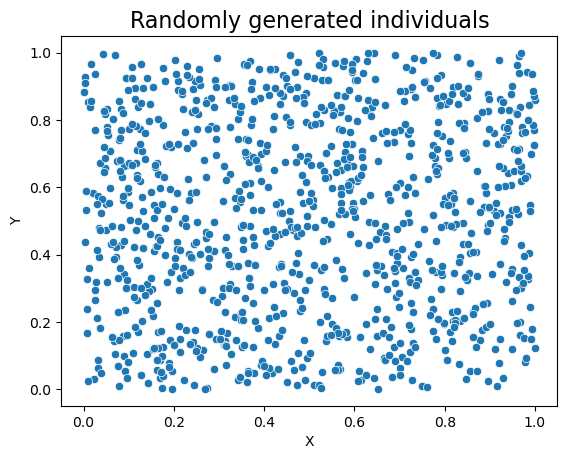

In [ ]:
# Convert list to numpy array
individuals = sample_uniform_random_individuals(n=1000)

# Print the first 10 individuals
fig = sns.scatterplot(x = individuals[:, 0], y = individuals[:, 1])
fig.set_title('Randomly generated individuals').set_fontsize('16')
fig.set_xlabel('X')
fig.set_ylabel('Y')

# Show the plot
plt.show()

##### A.2 - The `euclDistMatrix` function

The function `euclDistMatrix` computes the Euclidean distance between all pairs of individuals in a given map. The Euclidean distance between two individuals $i$ and $j$ is defined as follows:

$$
d(i,j) = \sqrt{(x_i - x_j)^2 + (y_i - y_j)^2}
$$

Pseudocode:

```
function euclDistMatrix(individuals):
    distMatrix <- NxN matrix of zeros (where N = |individuals|)
    for each individual i in individuals:
        for each individual j in individuals:
            distMatrix[i,j] <- sqrt((x_i - x_j)^2 + (y_i - y_j)^2)
        end for
    end for
    return distMatrix
end function
```

In [ ]:
def euclDistMatrix(individuals: np.ndarray) -> np.ndarray:
  '''
  Creates a n x n matrix of Euclidean distances between n individuals

  Args:
    individuals (np.ndarray): Array of tuples containing x and y coordinates of individuals

  Returns:
    np.ndarray: n x n matrix of Euclidean distances between n individuals
  '''

  # Create an empty n x n matrix
  distMatrix = np.zeros((individuals.shape[0], individuals.shape[0]))

  # Loop over all individuals
  for i in range(individuals.shape[0]):
    # Loop over all individuals again
    for j in range(individuals.shape[0]):
      # Calculate Euclidean distance between individual i and j
      distMatrix[i, j] = np.sqrt((individuals[i, 0] - individuals[j, 0])**2 + (individuals[i, 1] - individuals[j, 1])**2)

  return distMatrix


##### A.3 - The `distMatrixFromN` function

The function `distMatrixFromN`, given a number $n$ of individuals, performs the following steps 100 times:

1. Sample $n$ individuals randomly from a unit square map $[0,1]^2$.
2. Compute the Euclidean distance between all pairs of individuals in the map.
3. Computes summary information for the distance matrix such as the minimum, maximum, mean, median, and standard deviation of the distances.

For each of the summary statistics, the function returns a list of 100 values.

Pseudocode:

```
function distMatrixFromN(n)
    # Empty vectors to store statistics
    minDistances <- []
    maxDistances <- []
    meanDistances <- []
    medianDistances <- []
    stdDistances <- []

    # Execute 100 simulations
    for i = 1,2,...,100:
        # Sample n individuals function defined in point A.1
        individuals <- sample_uniform_random_individuals(n)
        distMatrix <- euclDistMatrix(individuals)
        minDistances <- minDistances UNION {min(distMatrix)}
        maxDistances <- maxDistances UNION {max(distMatrix)}
        meanDistances <- meanDistances UNION {mean(distMatrix)}
        medianDistances <- medianDistances UNION {median(distMatrix)}
        stdDistances <- stdDistances UNION {std(distMatrix)}
    end for
    return minDistances, maxDistances, meanDistances, medianDistances, stdDistances
end function
```

In [ ]:
def distMatrixFromN(n: int) -> pd.DataFrame:
  '''
  This function simulates 100 times the generation of n individuals and
  computes the minimum, maximum, mean, median and standard deviation of the distances on each of them.

  Args:
    n (int): Number of individuals to sample per simulation.

  Returns:
    pd.DataFrame: DataFrame containing 100 rows, each of them contains the computed statistics.
  '''

  # Empty list to store statistics
  minDistances = np.zeros(100)
  maxDistances = np.zeros(100)
  meanDistances = np.zeros(100)
  medianDistances = np.zeros(100)
  stdDistances = np.zeros(100)

  # Run the experiment 100 times
  for i in range(100):
    # Sample N individuals
    individuals = sample_uniform_random_individuals(n)
    # Compute distances between sampled individuals
    distMatrix = euclDistMatrix(individuals)

    # Compute + save statistics
    minDistances[i] = np.min(distMatrix)
    maxDistances[i] = np.max(distMatrix)
    meanDistances[i] = np.mean(distMatrix)
    medianDistances[i] = np.median(distMatrix)
    stdDistances[i] = np.std(distMatrix)

  # Create pandas DataFrame
  return pd.DataFrame({'minDistances': minDistances, 'maxDistances': maxDistances, 'meanDistances': meanDistances, 'medianDistances': medianDistances, 'stdDistances': stdDistances})

##### A.4 - The `erdosRenyiFromP` function

The function `erdosRenyiFromP` generates an Erdos-Renyí graph given the number of individuals $n$ and the probability $p$ of an edge between a couple of nodes.

Pseudocode:

```
function erdosRenyiFromP(n, p)
  adjency_matrix = N x N matrix of zeros (where N = n)

  # Cycle through each individual
  for individual i in 1,2,...n
    for individual j in 2,3,...n-1
      # Bernoulli simulation with probability p of positive outcome (having an edge between i and j)
      if (Bernoulli(p) == 1):
        adjency_matrix[i, j] = 1
      end if
    end for
  end for

  # Return adjency matrix
  return adjency_matrix

end function
```

$\textbf{\textcolor{red}{NEED TO ASK ON THE FORUM IF I CAN USE iGraph RATHER THAN PROGRAMMING ALL BY MYSELF!}}$

In [ ]:
def ErdosRenyiFromP(n, p):

#### B - Exploring alternative modeling approaches

$\textbf{\textcolor{red}{TODO: Add description}}$

#### B.1 - Exploring n

In this section will be explored the minimum, maximum and mean Euclidean distance on a randomly generated population of size $n$, analyzing the data with different sizes: 10, 100, 1000, 10000.

The simulations will be run using function `distMatrixFromN` defined earlier in point A.3 ($\textcolor{red}{\textbf{ADD MARKDOWN CROSS-REFERENCE}}$)

Pseudocode:

```
function exploringN()
  # Population sizes to test
  Ns <- [1,10,100,1000,10000]

  # Empty vector to store reports for each population size
  results <- []

  # Run simulation for each N
  for n in Ns
    result <- distMatrixFromN(n)
    results <- results UNION {result} 
  end for

  # Plot data to compare generated results
  plot(result)
end function
```

In [ ]:
ns = [1,10,100,1000,10000]

# Run simulations with different sizes
results: list[pd.DataFrame] = []
for n in ns:
  # Compute simulation + save result
  results.append(distMatrixFromN(n))
  

NameError: name 'distMatrixFromN' is not defined

#### B.1 - Exploring p

### Scenario 2